Best solution found: [0.52405161 0.26293291 0.18155158 0.30134789 0.14354232 0.00442688
 0.21761448 0.25882215 0.09585945]
Function value: [-10.08753585]
Constraint violation: [0.]


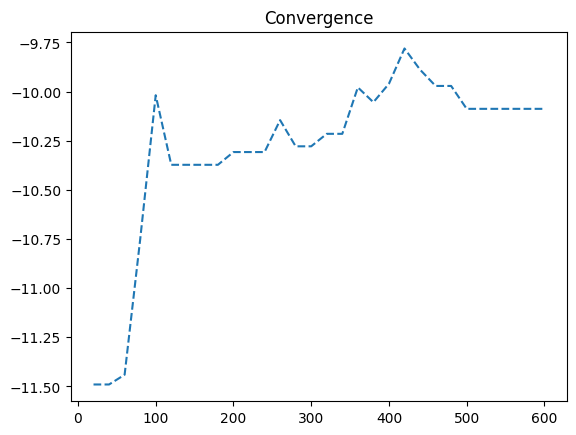

In [7]:
# https://github.com/samrat-nath/python-tests/blob/main/Optimization/store_site_selection_GA.py

"""
Solving a store site and type selection problem (a type of subset selection problem) 
by genetic algorithm using pymoo package
@author: Samrat Nath

https://pymoo.org/customization/discrete.html
https://pymoo.org/problems/definition.html
https://pymoo.org/algorithms/soo/ga.html#nb-ga
"""

#%% Importing Libraries
import numpy as np
from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.selection.rnd import RandomSelection
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.algorithms.soo.nonconvex.ga import GA

#%% Global variables for a custom store site  and type selection problem
# Matrices for Financial Estimates (in Millions)
S_mat = np.array([[75, 50, 25], [70, 40, 20], [65, 35, 15]])     # Sales 
C_mat = np.array([[35, 20, 10], [35, 20, 10], [30, 18, 8]])     # Cost
N_mat = np.array([[10, 6, 4], [10, 5, 3], [9, 5, 3]])     # Net NPV Gain
I_mat = np.array([[3, 2, 1], [3, 2, 1], [3, 2, 1]])     # Impact
# Vector Representations
sales, cost, npv, impact = S_mat.flatten(), C_mat.flatten(), N_mat.flatten(), I_mat.flatten()

# Sample solution (Pop=2) 
# x = np.array([[0, 1, 0, 1, 0, 0, 0, 0, 0],
#               [0, 1, 0, 0, 0, 0, 1, 0, 0]])

# Business Constraint (in Millions)
CAPEX_LIMIT = 55    # Capital Expenditure Limit                            
MIN_MKT_SALES = 105  # Minimum Sales from market

NUM_LOC = 3      # Number of possible locations for new stores
NUM_FMT = 3      # Number of store formats/types
STORE_LIMIT = 2  # Number of Total Stores Limit

con_mat = np.zeros((NUM_FMT*NUM_LOC, NUM_LOC), dtype=int)
for i in range(NUM_LOC):
    con_mat[i*NUM_FMT:(i+1)*NUM_FMT,i] = 1 

#%% Problem Definiton
class MyProblem(Problem):
    # Definition of a custom Knapsack problem
    def __init__(self):
        super().__init__(n_var = NUM_LOC*NUM_FMT,
                         n_obj = 1,
                         n_constr = NUM_LOC+3,
                         xl = 0,
                         xu = 1,
                         type_var = int
                         )

    def _evaluate(self, X, out, *args, **kwargs):
        # Objective and Constraint functions
        out["F"] = -np.sum(X*(npv-impact), axis=1)      # Objetive Value
        g1 = np.sum(X*cost, axis=1) - CAPEX_LIMIT  # CAPEX constraint
        g2 = -(np.sum(X*sales, axis=1) - MIN_MKT_SALES)  # SALES constraint
        g3 = (X@con_mat) -1  # Store format constraint (max 1 type per location
        g4 = np.sum(X, axis=1) - STORE_LIMIT           
        out["G"] = np.column_stack([g1, g2, g3, g4]) 

#%% Solution
# method = get_algorithm("ga",
#                        pop_size=20,
#                        sampling=RandomSelection(),
#                        crossover=SBX(prob=1.0, eta=3.0),
#                        mutation=PolynomialMutation(prob=0.1, eta=3.0),
#                        eliminate_duplicates=True,
#                        )

algorithm = GA(
    pop_size=20,
    eliminate_duplicates=True)

res = minimize(MyProblem(),
               algorithm,
               termination=('n_gen', 30),
               seed=1,
               save_history=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

#%% Visualization of Convergence 

import matplotlib.pyplot as plt
# number of evaluations in each generation
n_evals = np.array([e.evaluator.n_eval for e in res.history])  
# optimum value in each generation
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt, "--")
plt.show()

In [10]:
print(sales, cost, npv, impact )
print(S_mat)
print(con_mat)

[75 50 25 70 40 20 65 35 15] [35 20 10 35 20 10 30 18  8] [10  6  4 10  5  3  9  5  3] [3 2 1 3 2 1 3 2 1]
[[75 50 25]
 [70 40 20]
 [65 35 15]]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
